In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim


In [135]:
DF_cleaned=pd.read_csv('DF_nettoyé.csv')

ON DROP UNE COLONNE DU ONE HOT ENCODE POUR LA REGRESSION LINEAIRE

In [136]:
DF_cleaned_lineaire=DF_cleaned.drop(['PrimaryPropertyType_Autres'],axis=1)

ON DROP LA COLONNE SiteEnergyUseWN(kBtu) NON DISPONIBLE DANS L'ETUDE

In [137]:
DF_cleaned_lineaire=DF_cleaned_lineaire.drop(['SiteEnergyUseWN(kBtu)'],axis=1)

In [138]:
col_num=[]
col_obj=[]
for col in DF_cleaned_lineaire.columns:
    if DF_cleaned_lineaire[col].dtype in ['int64','float64'] :
        col_num.append(col)
    else:
        col_obj.append(col)

In [139]:
print(col_num)

['OSEBuildingID', 'ZipCode', 'CouncilDistrictCode', 'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'TotalGHGEmissions', 'AGE', '%_elec(kBtu)', '%_gas(kBtu)', '%_steam(kBtu)', '%_parking', '%_immeuble', 'PrimaryPropertyType_Education et Services Communautaires', 'PrimaryPropertyType_Immobilier Commercial', 'PrimaryPropertyType_Logistique et Stockage', 'PrimaryPropertyType_Santé']


In [140]:
colonne_à_retirer=[]
for col in col_num:
    if DF_cleaned_lineaire[col].isna().sum()!=0:
        colonne_à_retirer.append(col)
print(colonne_à_retirer)
for t in colonne_à_retirer:
    del(col_num[col_num.index(t)])

['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore']


In [141]:
print(col_num)

['OSEBuildingID', 'ZipCode', 'CouncilDistrictCode', 'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'TotalGHGEmissions', 'AGE', '%_elec(kBtu)', '%_gas(kBtu)', '%_steam(kBtu)', '%_parking', '%_immeuble', 'PrimaryPropertyType_Education et Services Communautaires', 'PrimaryPropertyType_Immobilier Commercial', 'PrimaryPropertyType_Logistique et Stockage', 'PrimaryPropertyType_Santé']


# VERIFICATION DES HYPOTHESES DE LA REGRESSION LINEAIRE

## 1) ETUDE DU VIF ( Varaince Inflation Factor )

In [142]:

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

data =DF_cleaned_lineaire[col_num]
X = sm.add_constant(data)

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

print("\n Analyse VIF (multicolinéarité)")
vif_data = calculate_vif(X.drop('const', axis=1))
print(vif_data)


 Analyse VIF (multicolinéarité)
                                             Variable           VIF
14                                         %_immeuble  5.413613e+07
13                                          %_parking  1.583174e+06
11                                        %_gas(kBtu)  5.379085e+04
10                                       %_elec(kBtu)  5.361897e+04
12                                      %_steam(kBtu)  6.642379e+03
7                                    PropertyGFATotal  3.175108e+00
6                                      NumberofFloors  2.638391e+00
16          PrimaryPropertyType_Immobilier Commercial  2.614646e+00
8                                   TotalGHGEmissions  2.346935e+00
17         PrimaryPropertyType_Logistique et Stockage  2.225826e+00
2                                 CouncilDistrictCode  2.157070e+00
15  PrimaryPropertyType_Education et Services Comm...  1.758400e+00
3                                            Latitude  1.626990e+00
5              

## 2) SCATTER PLOTS

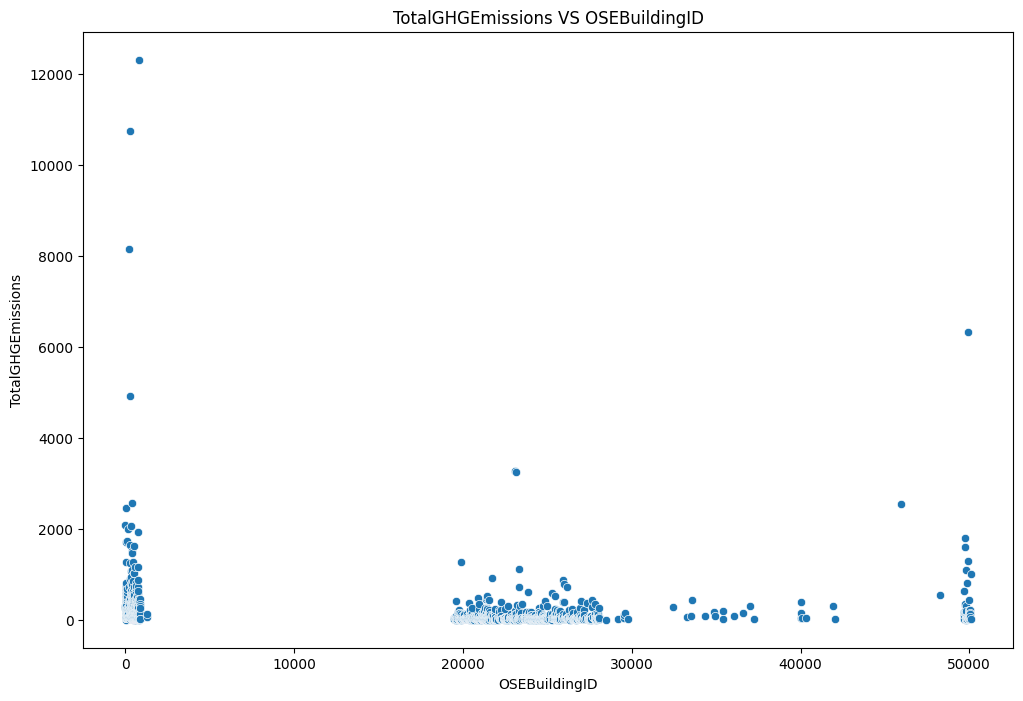

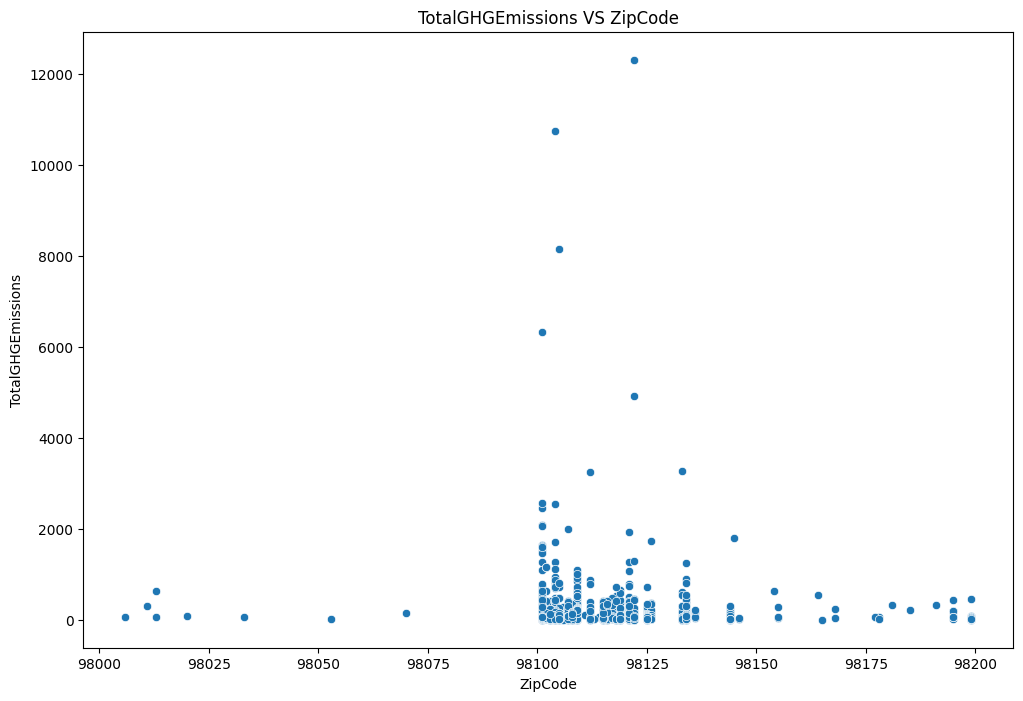

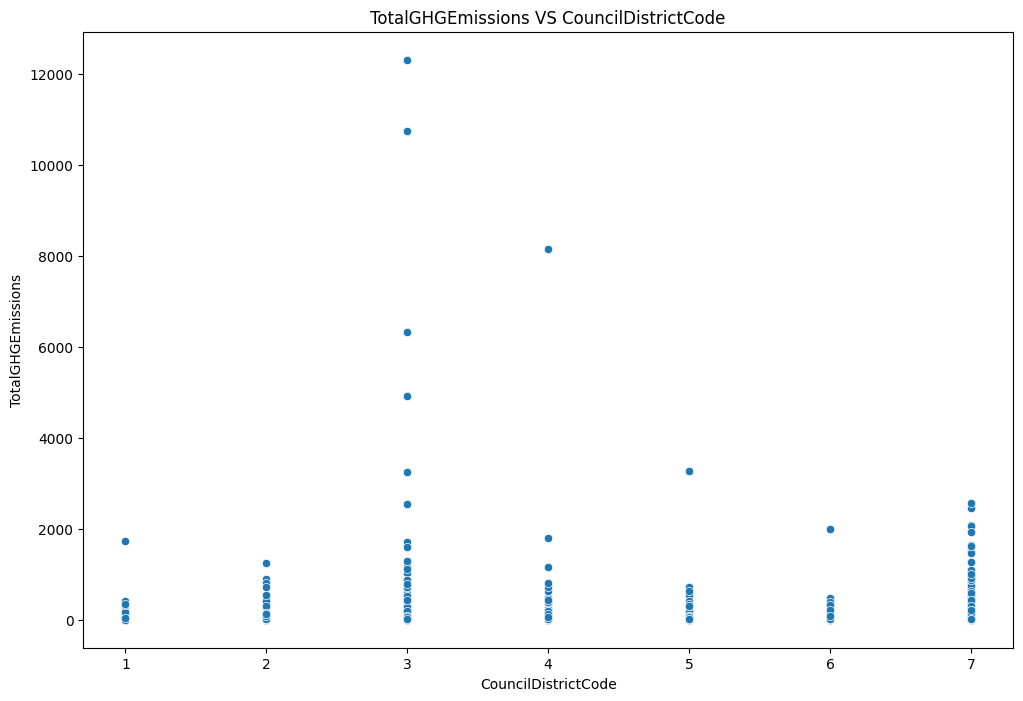

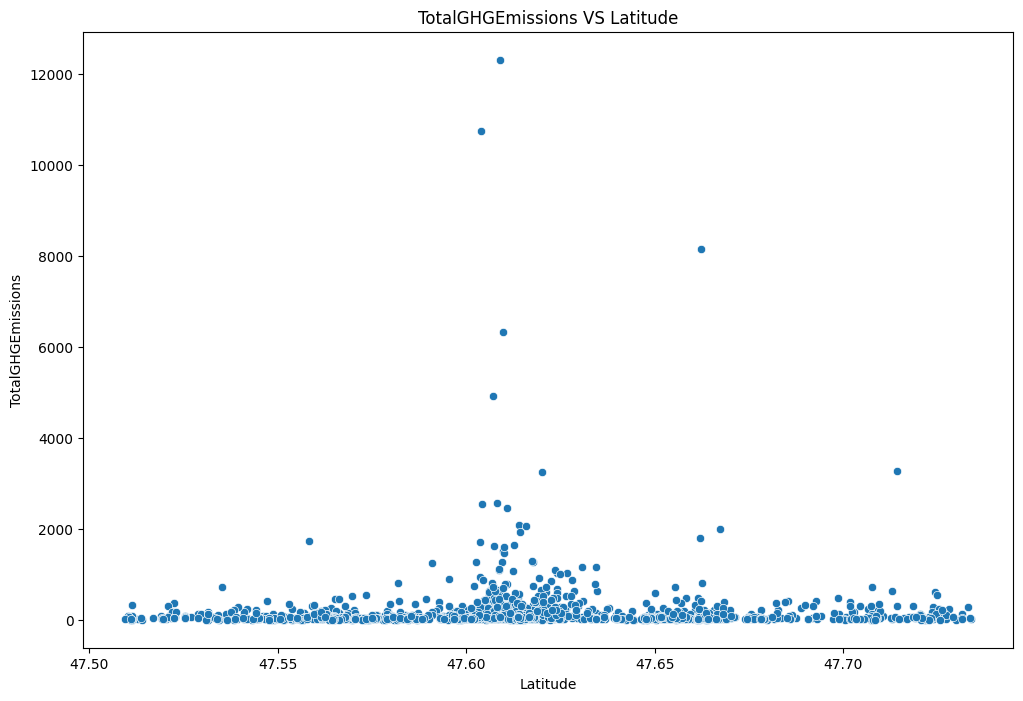

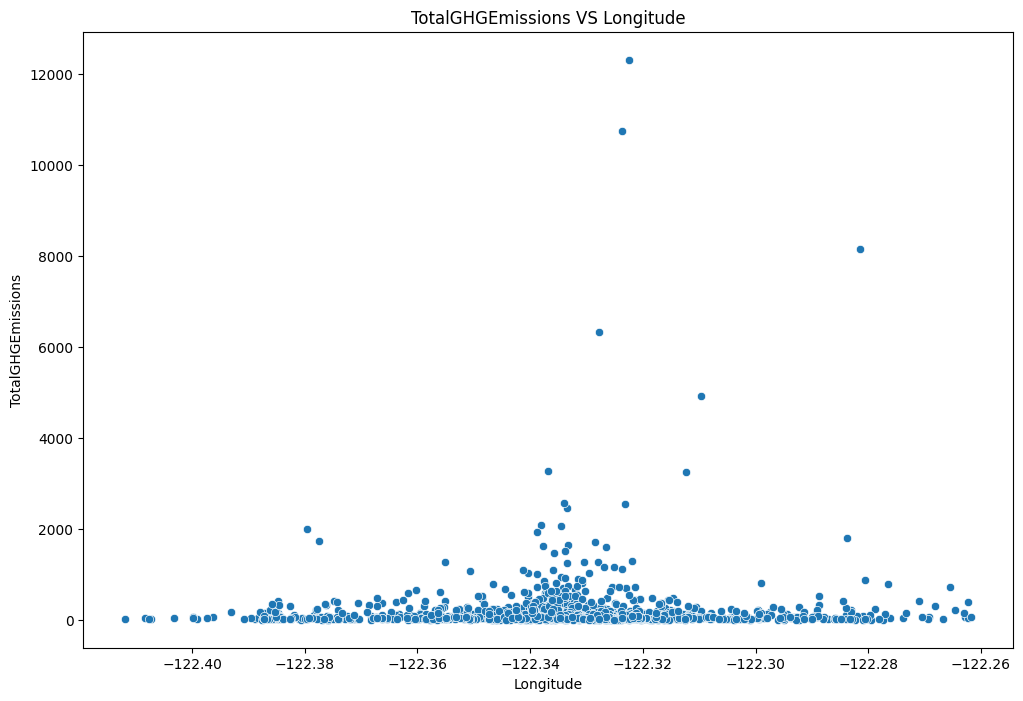

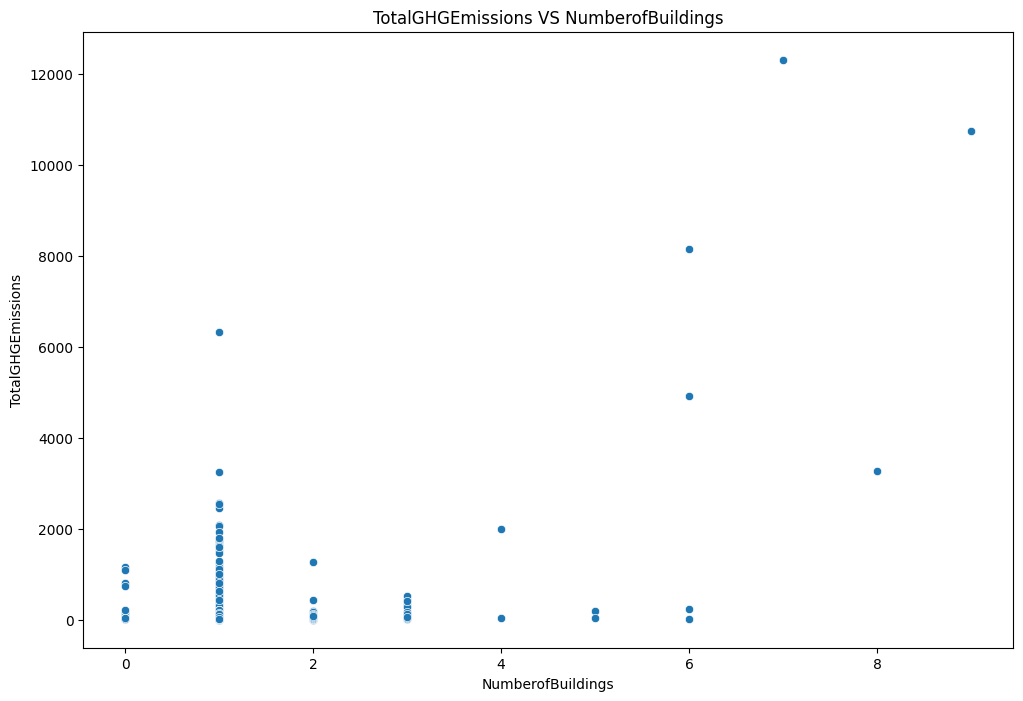

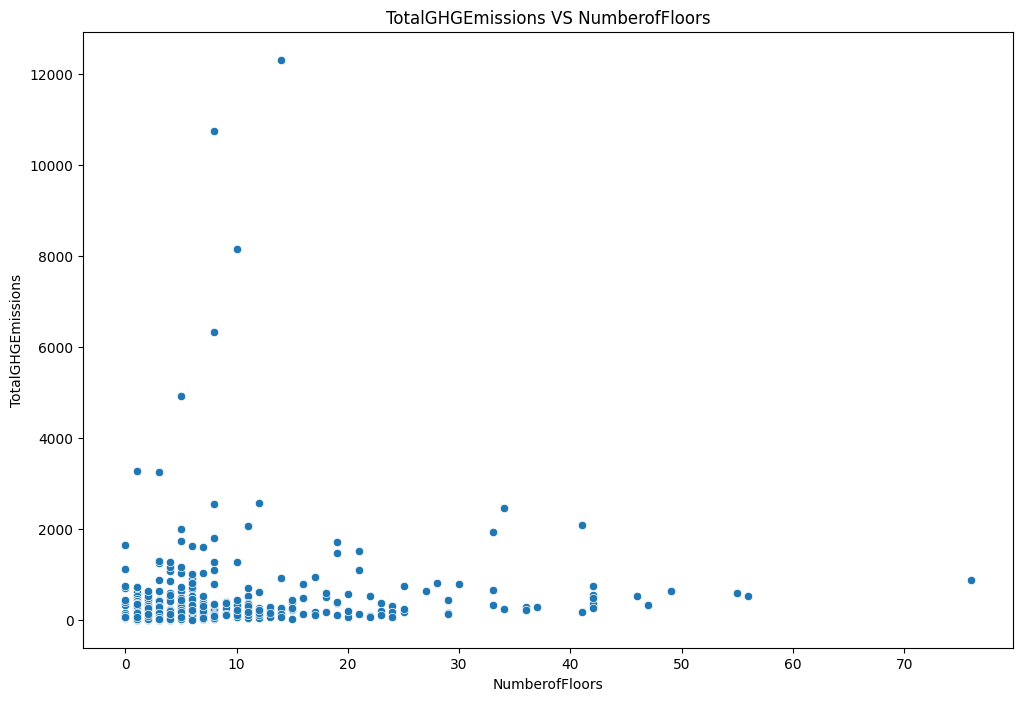

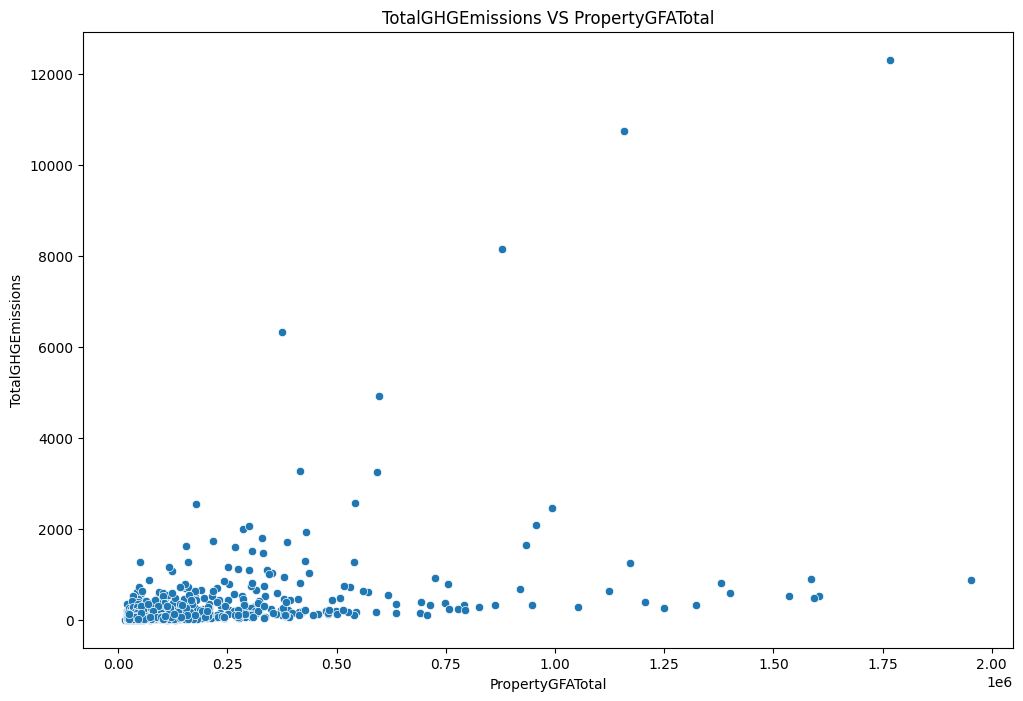

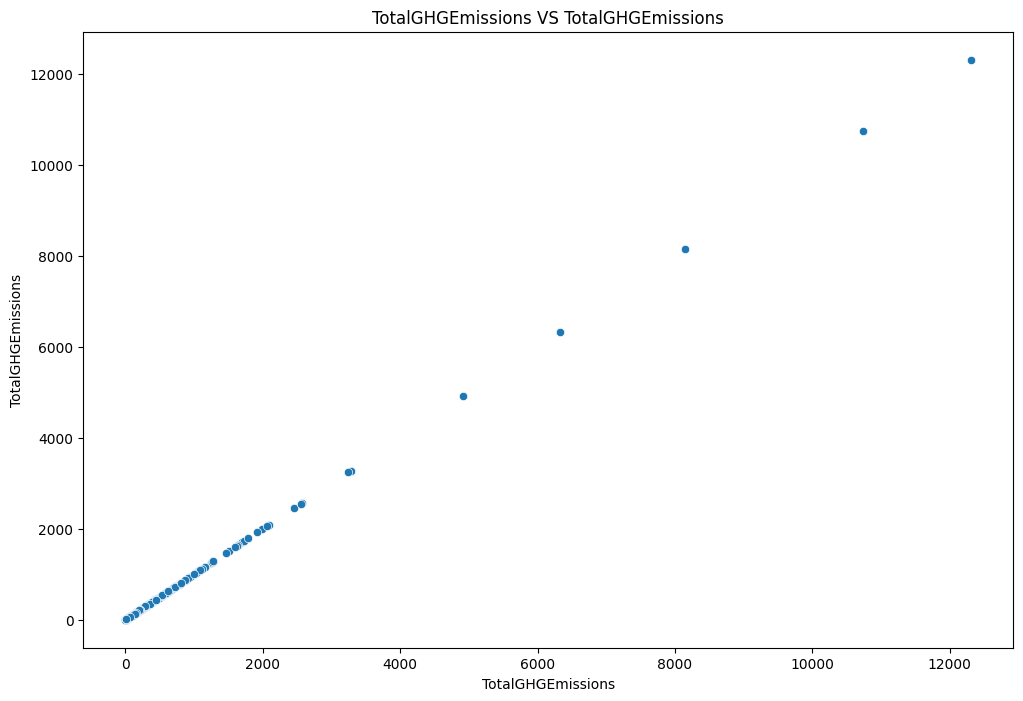

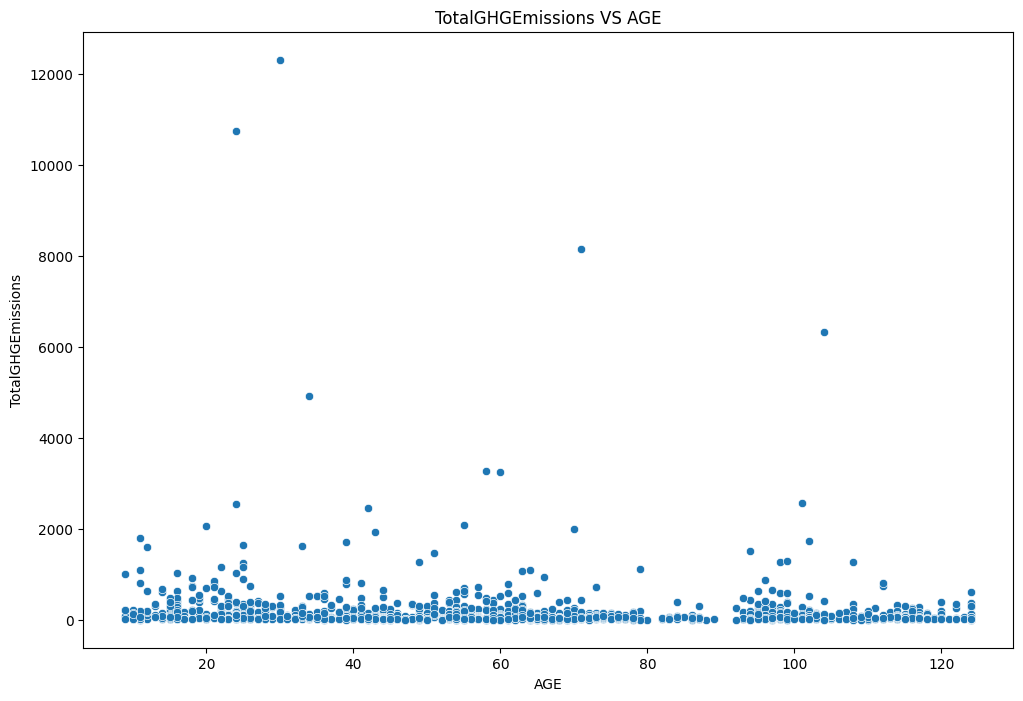

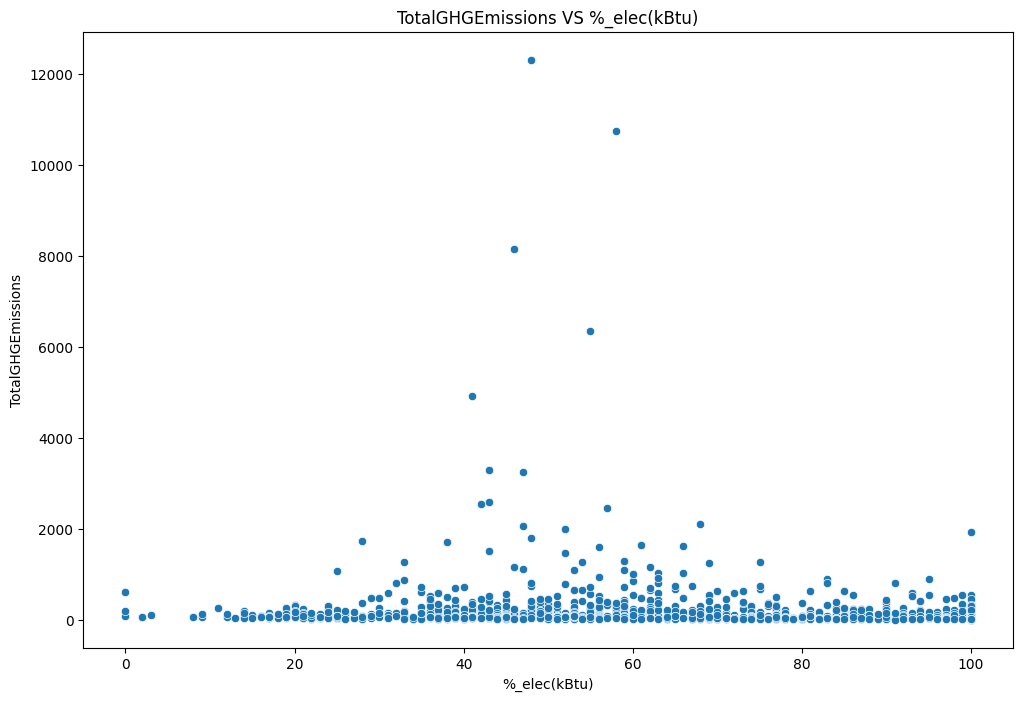

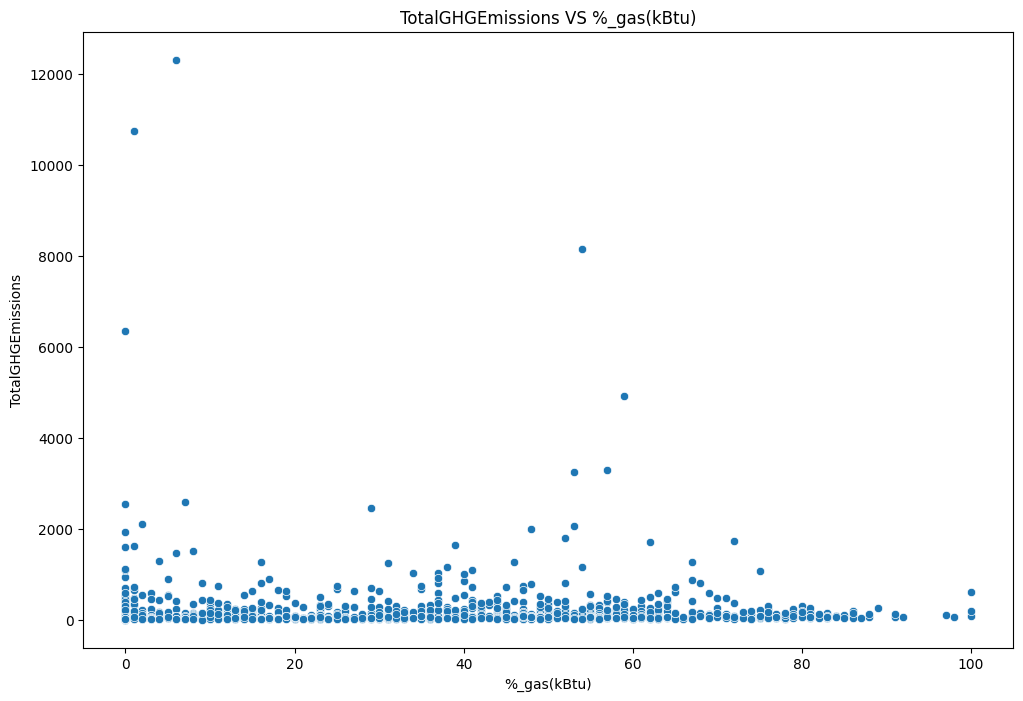

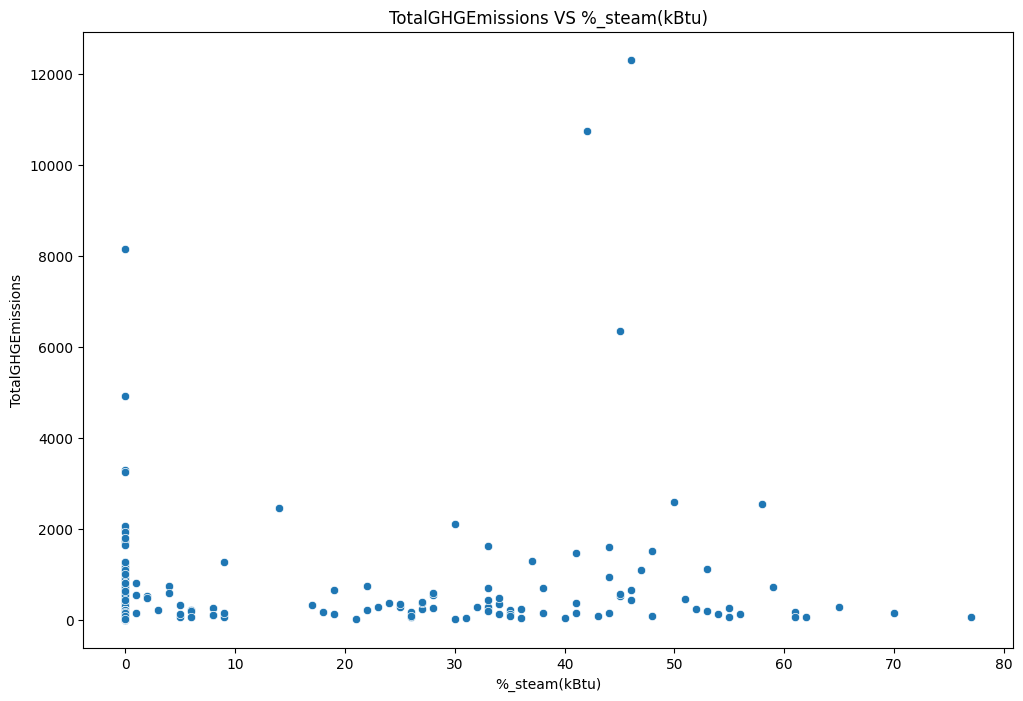

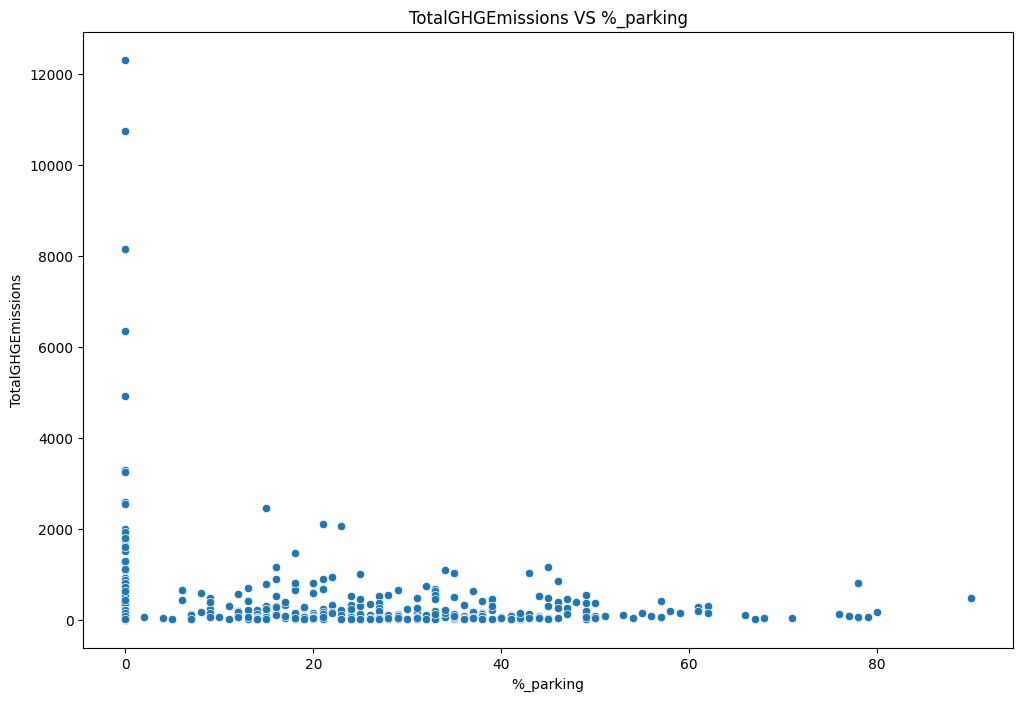

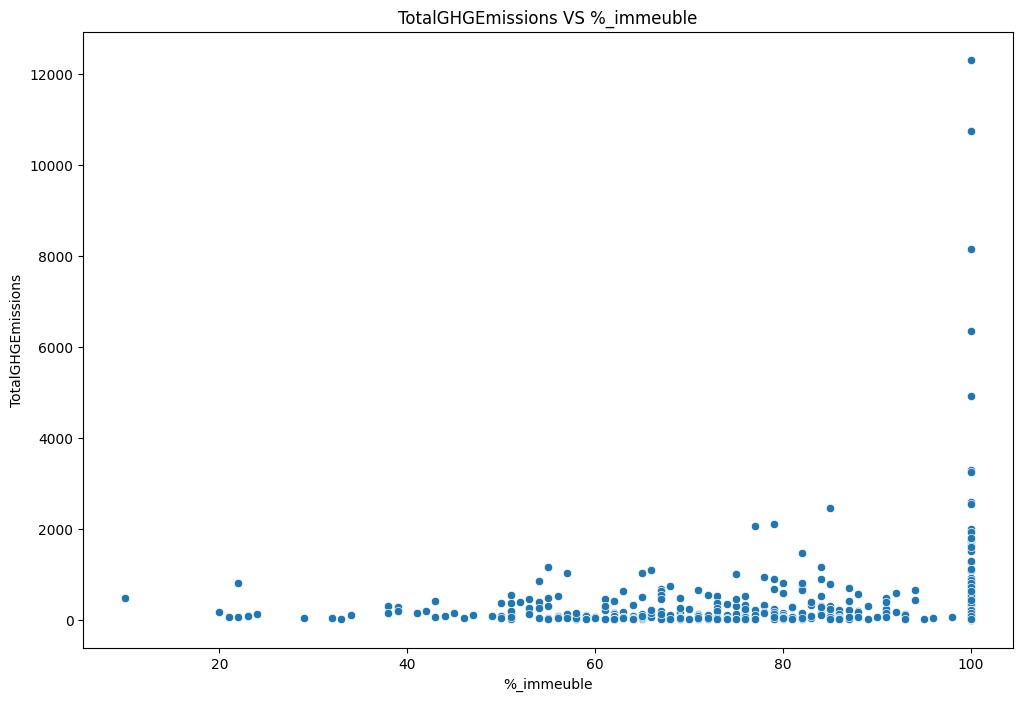

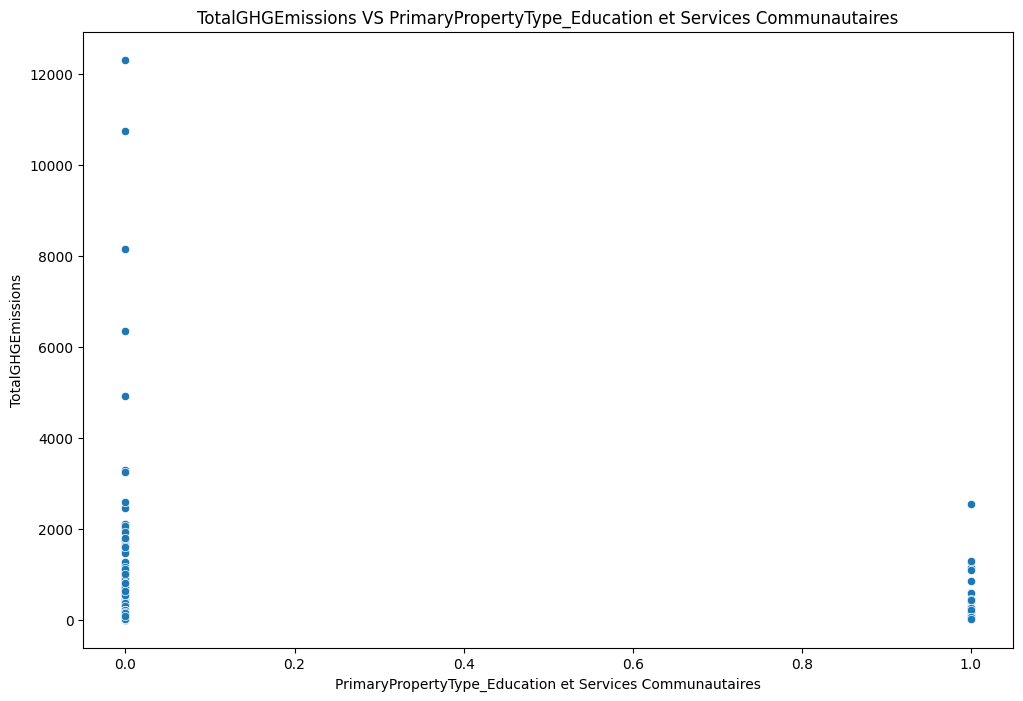

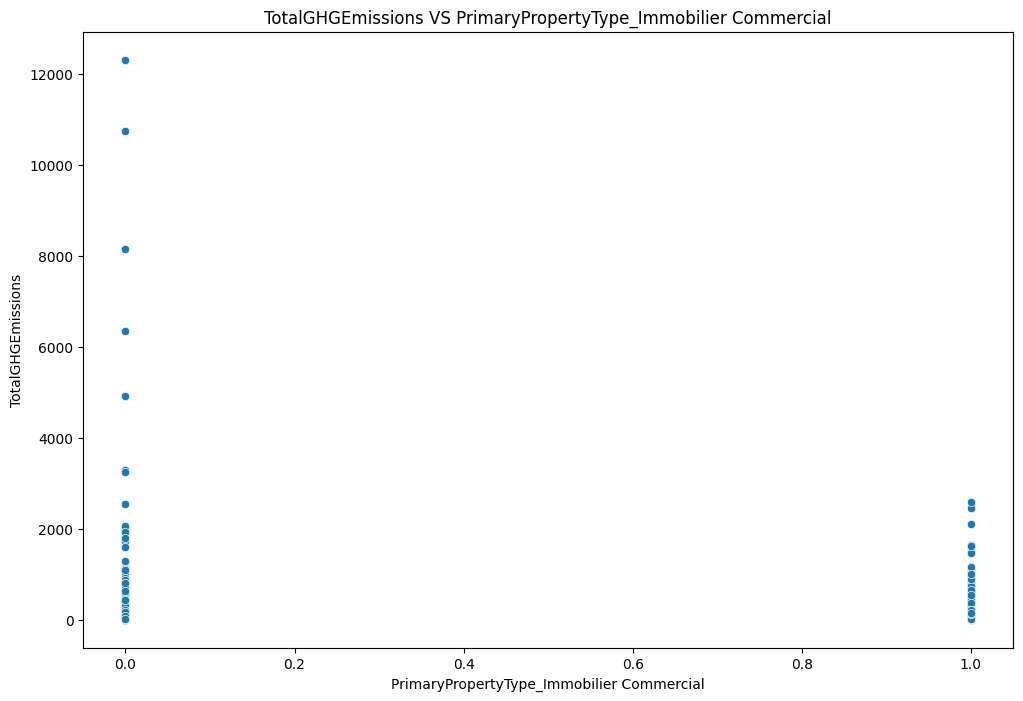

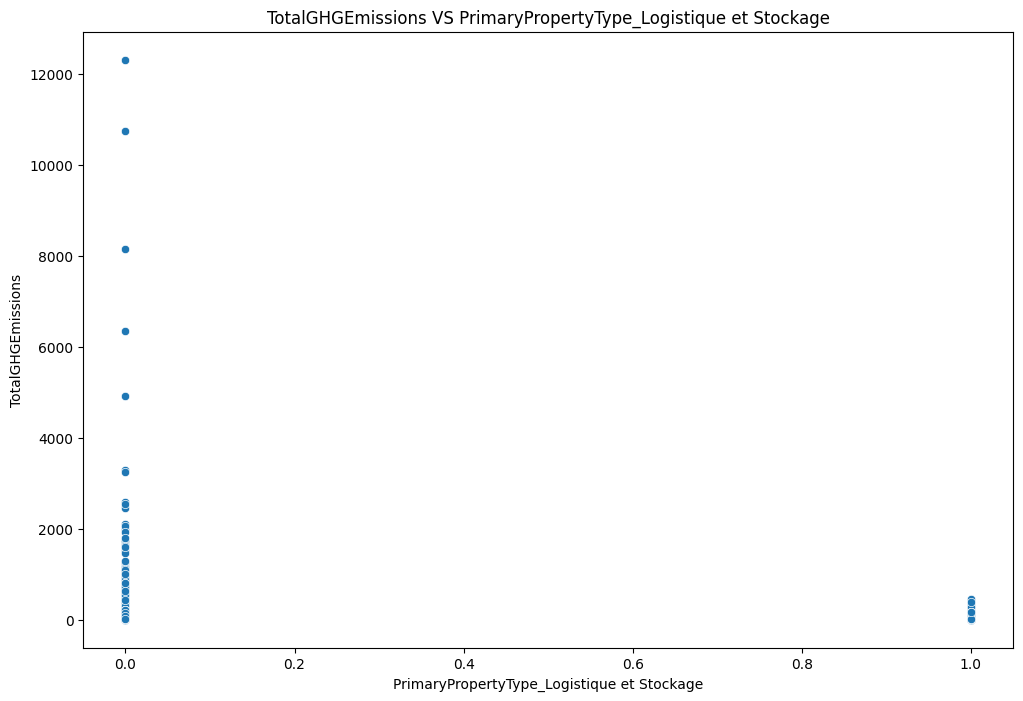

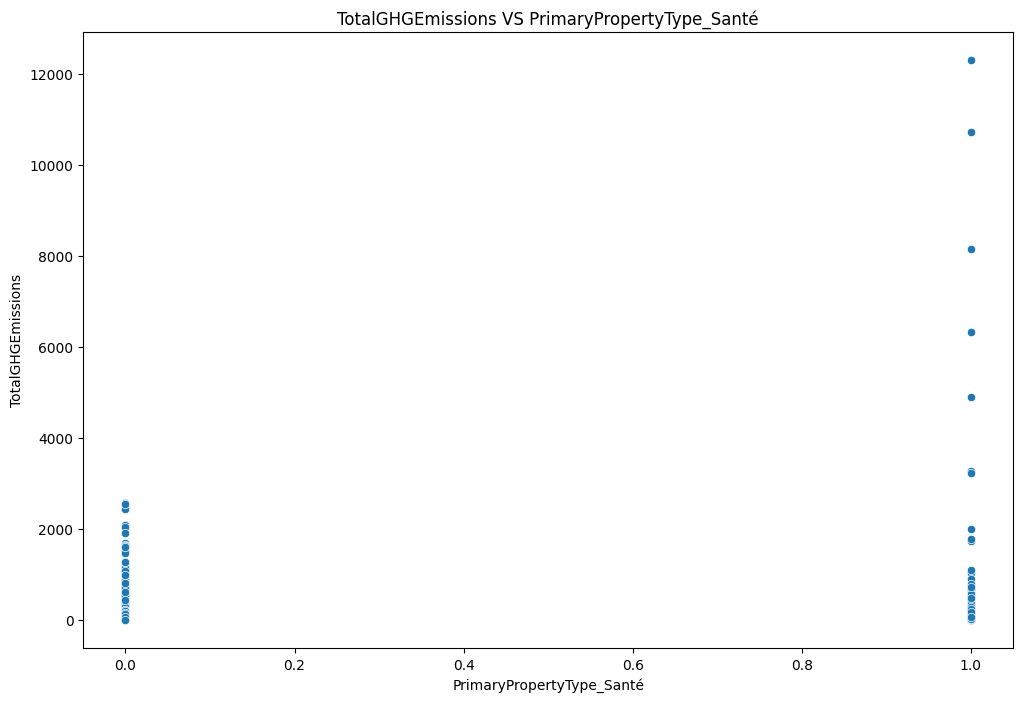

In [143]:
for col in col_num:
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=DF_cleaned_lineaire[col],y=DF_cleaned_lineaire['TotalGHGEmissions'])
    plt.title(f'TotalGHGEmissions VS {col}')
    plt.show()

## CREATION ET ENTRAINEMENT DU MODELE

In [144]:

y=DF_cleaned_lineaire['TotalGHGEmissions']
X=DF_cleaned_lineaire[col_num].drop(['TotalGHGEmissions'],axis=1)

X=sm.add_constant(X)

In [145]:
model = sm.OLS(y,X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      TotalGHGEmissions   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     111.8
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          1.10e-246
Time:                        10:17:19   Log-Likelihood:                -10539.
No. Observations:                1429   AIC:                         2.111e+04
Df Residuals:                    1411   BIC:                         2.121e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

## SELECTION VARIABLES

1. Analyse des corrélations

Corrélations avec TotalGHGEmissions:
TotalGHGEmissions                                           1.000000
NumberofBuildings                                           0.569583
PropertyGFATotal                                            0.471957
PrimaryPropertyType_Santé                                   0.315150
%_steam(kBtu)                                               0.286247
NumberofFloors                                              0.207213
Longitude                                                   0.045032
%_gas(kBtu)                                                 0.036489
CouncilDistrictCode                                         0.033998
Latitude                                                    0.020875
%_parking                                                   0.019029
%_immeuble                                                 -0.019029
PrimaryPropertyType_Education et Services Communautaires   -0.021773
PrimaryPropertyType_Immobilier Commer

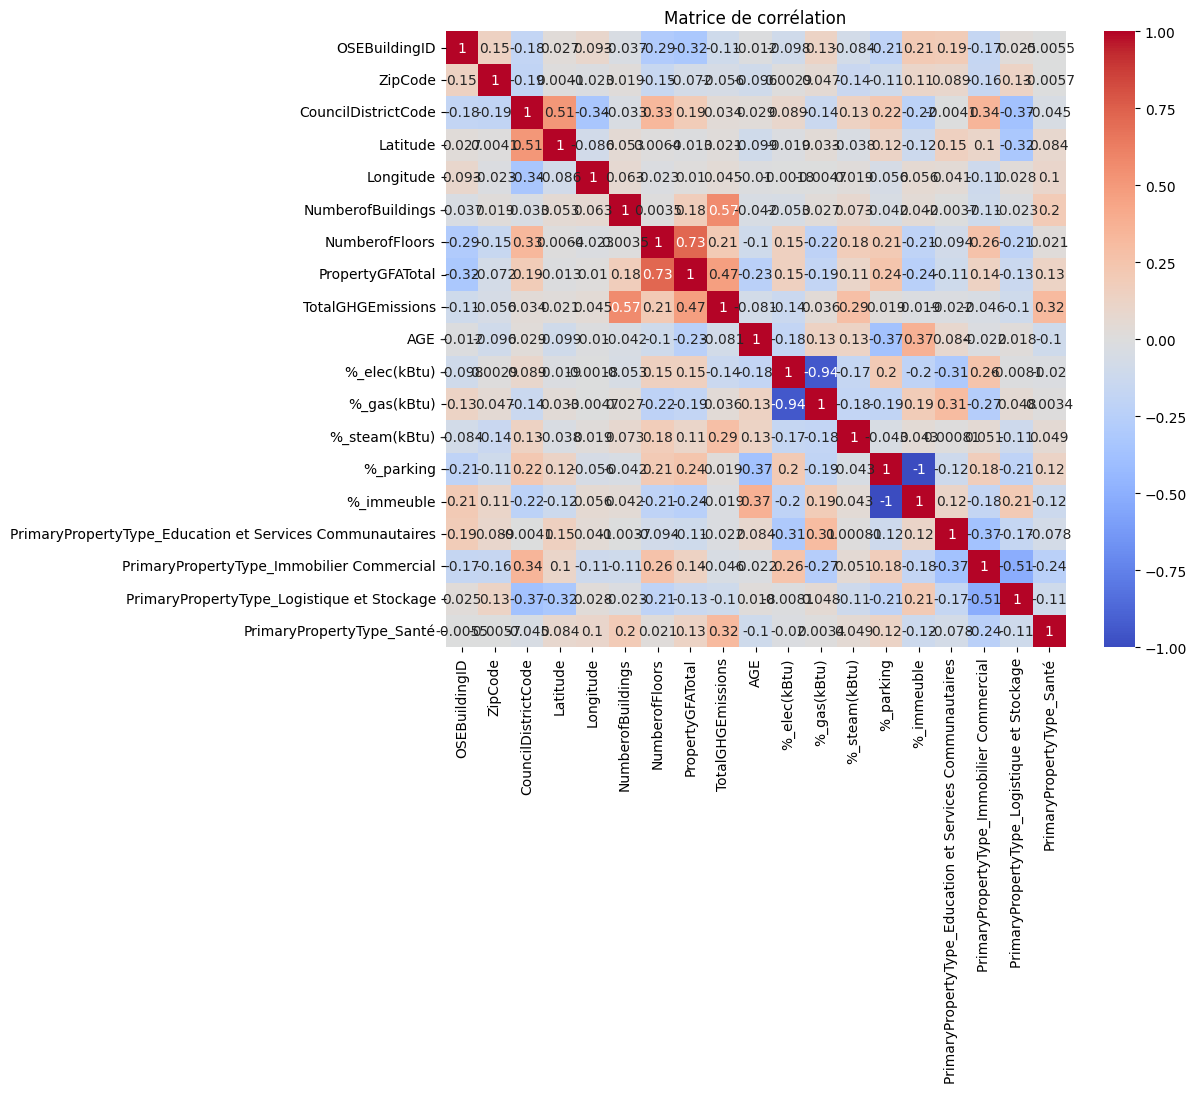

In [146]:


from scipy import stats



data=DF_cleaned_lineaire[col_num]


# 1. Analyse des corrélations
print("1. Analyse des corrélations")
correlations = data.corr()['TotalGHGEmissions'].sort_values(ascending=False)
print("\nCorrélations avec TotalGHGEmissions:")
print(correlations)

# Visualisation de la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation')
plt.show()


In [147]:

# 2. Test de significativité individuelle
print("\n2. Tests de significativité individuelle")
X = sm.add_constant(data.drop('TotalGHGEmissions', axis=1))
model = sm.OLS(data['TotalGHGEmissions'], X).fit()
print("\nRésumé des p-values:")
p_values = pd.DataFrame({
    'Variable': X.columns,
    'P-value': model.pvalues,
    'Significatif': model.pvalues < 0.05
}).sort_values('P-value')
print(p_values)



2. Tests de significativité individuelle

Résumé des p-values:
                                                                                             Variable  \
NumberofBuildings                                                                   NumberofBuildings   
PropertyGFATotal                                                                     PropertyGFATotal   
PrimaryPropertyType_Santé                                                   PrimaryPropertyType_Santé   
NumberofFloors                                                                         NumberofFloors   
ZipCode                                                                                       ZipCode   
PrimaryPropertyType_Immobilier Commercial                   PrimaryPropertyType_Immobilier Commercial   
OSEBuildingID                                                                           OSEBuildingID   
%_steam(kBtu)                                                                           %_steam(

In [148]:

# 3. Analyse VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_data.loc[vif_data["VIF"]==float('inf')]['Variable'].tolist())
    return vif_data.sort_values('VIF', ascending=False)

print("\n3. Analyse VIF (multicolinéarité)")
vif_data = calculate_vif(X.drop('const', axis=1))
print(vif_data)



3. Analyse VIF (multicolinéarité)
[]
                                             Variable           VIF
13                                         %_immeuble  5.412990e+07
12                                          %_parking  1.582994e+06
10                                        %_gas(kBtu)  5.376792e+04
9                                        %_elec(kBtu)  5.359792e+04
11                                      %_steam(kBtu)  6.638425e+03
15          PrimaryPropertyType_Immobilier Commercial  2.610704e+00
6                                      NumberofFloors  2.553200e+00
7                                    PropertyGFATotal  2.543105e+00
16         PrimaryPropertyType_Logistique et Stockage  2.225312e+00
2                                 CouncilDistrictCode  2.156789e+00
14  PrimaryPropertyType_Education et Services Comm...  1.758386e+00
3                                            Latitude  1.626971e+00
17                          PrimaryPropertyType_Santé  1.376310e+00
8         

In [149]:

# 4. Analyse des R² ajustés avec différentes combinaisons
def evaluate_feature_importance(data):
    results = []
    base_features = []
    remaining_features = list(data.drop('TotalGHGEmissions', axis=1).columns)
    
    while remaining_features:
        best_score = -np.inf
        best_feature = None
        
        for feature in remaining_features:
            current_features = base_features + [feature]
            X = sm.add_constant(data[current_features])
            model = sm.OLS(data['TotalGHGEmissions'], X).fit()
            score = model.rsquared_adj
            
            results.append({
                'features': ', '.join(current_features),
                'feature_added': feature,
                'r2_adj': score
            })
            
            if score > best_score:
                best_score = score
                best_feature = feature
        
        if best_feature:
            base_features.append(best_feature)
            remaining_features.remove(best_feature)
            
    return pd.DataFrame(results)

print("\n4. Analyse progressive des caractéristiques")
feature_importance = evaluate_feature_importance(data=data)
print(feature_importance.sort_values('r2_adj', ascending=False).head())



4. Analyse progressive des caractéristiques
                                              features  feature_added  \
126  NumberofBuildings, PropertyGFATotal, %_steam(k...  OSEBuildingID   
140  NumberofBuildings, PropertyGFATotal, %_steam(k...     %_immeuble   
139  NumberofBuildings, PropertyGFATotal, %_steam(k...   %_elec(kBtu)   
147  NumberofBuildings, PropertyGFATotal, %_steam(k...   %_elec(kBtu)   
145  NumberofBuildings, PropertyGFATotal, %_steam(k...      Longitude   

       r2_adj  
126  0.570276  
140  0.570276  
139  0.570159  
147  0.570159  
145  0.570134  


In [150]:

# 5. Sélection finale des variables
def select_significant_variables(data, threshold_p_value=0.05, threshold_vif=125):
    # Première étape : sélection basée sur p-value
    X = sm.add_constant(data.drop('TotalGHGEmissions', axis=1))
    model = sm.OLS(data['TotalGHGEmissions'], X).fit()
    significant_vars = X.columns[model.pvalues < threshold_p_value].tolist()
    
    
    # Deuxième étape : vérification VIF
    selected_vars = []
    X_significant = X[significant_vars]
    vif_data = calculate_vif(X_significant)
    
    for var in significant_vars:
        if var!='const' and vif_data[vif_data['Variable'] == var]['VIF'].values[0] < threshold_vif :
            selected_vars.append(var)
    #selected_vars.remove('const')
    return selected_vars

print("\n5. Sélection finale des variables")
selected_vars = select_significant_variables(data)
print("\nVariables sélectionnées:")
print(selected_vars)



5. Sélection finale des variables
[]

Variables sélectionnées:
['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PrimaryPropertyType_Santé']


In [151]:

# Modèle final avec les variables sélectionnées
X_final = sm.add_constant(data[selected_vars])
final_model = sm.OLS(data['TotalGHGEmissions'], X_final).fit()
print("\nRésumé du modèle final:")
print(final_model.summary())


Résumé du modèle final:
                            OLS Regression Results                            
Dep. Variable:      TotalGHGEmissions   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     362.1
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          3.78e-215
Time:                        10:17:21   Log-Likelihood:                -10647.
No. Observations:                1429   AIC:                         2.130e+04
Df Residuals:                    1424   BIC:                         2.133e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [152]:
print(selected_vars)

['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PrimaryPropertyType_Santé']


In [153]:


col_num=selected_vars
print(col_num)

['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PrimaryPropertyType_Santé']


### vERIFICATION DES CORRELATIONS

In [154]:
def check_correlations(data, threshold=0.95):
    corr_matrix = data.corr().abs()
    high_corr = np.where(corr_matrix > threshold)
    pairs = [(data.columns[i], data.columns[j], corr_matrix.iloc[i,j]) 
             for i, j in zip(*high_corr) if i < j]
    if pairs:
        print("Attention : Fortes corrélations détectées")
        for var1, var2, corr in pairs:
            print(f"{var1} - {var2}: {corr:.3f}")
    return pairs
print('Voilà les features qui semblent corrélées entre elles :')
check_correlations(DF_cleaned[col_num])

Voilà les features qui semblent corrélées entre elles :


[]

# 2) 'TotalGHGEmissions'

In [155]:
print(selected_vars)

['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PrimaryPropertyType_Santé']


In [156]:

col_num=selected_vars
print(col_num)

['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PrimaryPropertyType_Santé']


### DUMMY

In [157]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error,r2_score

X=DF_cleaned_lineaire[col_num]
y=DF_cleaned_lineaire['TotalGHGEmissions']

# Séparation train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un Dummy Regressor qui prédit la moyenne
dummy_reg = DummyRegressor(strategy="mean")

# Entraîner le modèle
dummy_reg.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = dummy_reg.predict(X_test)

# Calculer l'erreur quadratique moyenne (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculer la racine de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculer le coefficient de détermination R²
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")


Mean Squared Error: 61996.97097699347
Root Mean Squared Error: 248.99190946091696
R² Score: -0.04218013398235021


### REGRESSION LINEAIRE

In [158]:
from sklearn.linear_model import LinearRegression

# Créer et entraîner un modèle de régression linéaire
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Prédictions
y_pred_linear = np.maximum(0,linear_reg.predict(X_test))

# Évaluation
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Linear Regression MSE: {mse_linear}")
print(f"Linear Regression R² Score: {r2_linear}")


Linear Regression MSE: 61039.88125595169
Linear Regression R² Score: -0.026091285156516486


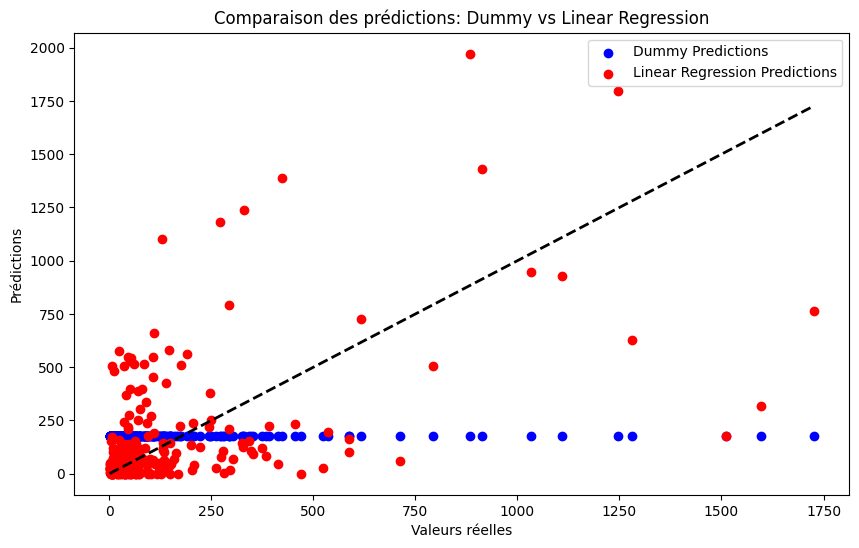

In [159]:


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Dummy Predictions')
plt.scatter(y_test, y_pred_linear, color='red', label='Linear Regression Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Comparaison des prédictions: Dummy vs Linear Regression')
plt.legend()
plt.show()

In [160]:

y_pred=y_pred_linear


seuil = 0.5*DF_cleaned_lineaire['TotalGHGEmissions'].mean()
# 1. Calculer l'erreur absolue
erreur = np.abs(y_test - y_pred_linear)

# 2. Créer un masque pour les erreurs inférieures au seuil
masque = erreur < seuil

# 3. Obtenir les entrées correspondantes
bonnes_predictions = X_test[masque]
leurs_erreurs = erreur[masque]

# 4. Créer un DataFrame pour une meilleure visualisation
resultats = pd.DataFrame({
    'Vraies_valeurs': y_test[masque],
    'Predictions': y_pred[masque],
    'Erreur(%)': (np.abs(y_test[masque] - y_pred[masque]) / np.abs(y_test[masque])) * 100
})

# 5. Inclure les features originales
resultats = pd.concat([bonnes_predictions, resultats], axis=1)

# 6. Afficher quelques statistiques
print(f"Nombre total de prédictions : {len(y_test)}")
print(f"Nombre de prédictions sous le seuil : {masque.sum()}")
print(f"Pourcentage de bonnes prédictions : {(masque.sum()/len(y_test))*100:.2f}%")
print(seuil*100/DF_cleaned_lineaire['TotalGHGEmissions'].mean())
# 7. Trier par erreur croissante
resultats['Erreur(%)'] = resultats['Erreur(%)'].round(2)
resultats = resultats.sort_values('Erreur(%)')
resultats

Nombre total de prédictions : 286
Nombre de prédictions sous le seuil : 190
Pourcentage de bonnes prédictions : 66.43%
50.00000000000001


,NumberofBuildings,NumberofFloors,PropertyGFATotal,PrimaryPropertyType_Santé,Vraies_valeurs,Predictions,Erreur(%)
303,1.0,1,57540,0.0,76.68,76.745142,0.08
1151,1.0,1,26440,0.0,27.93,27.983519,0.19
590,1.0,2,44098,0.0,41.69,41.324099,0.88
221,1.0,5,206950,0.0,249.09,253.623320,1.82
99,1.0,3,44558,0.0,28.27,27.699972,2.02
...,...,...,...,...,...,...,...
1307,1.0,1,23232,0.0,0.89,22.953703,2479.07
649,1.0,1,39350,0.0,1.86,48.225080,2492.75
1110,1.0,1,24248,0.0,0.79,24.546687,3007.18
1112,1.0,1,24617,0.0,0.75,25.125241,3250.03


In [161]:
resultats.loc[resultats['Erreur(%)']<=10].shape

(13, 7)

In [162]:
resultats['Erreur(%)'].max()

3799.0

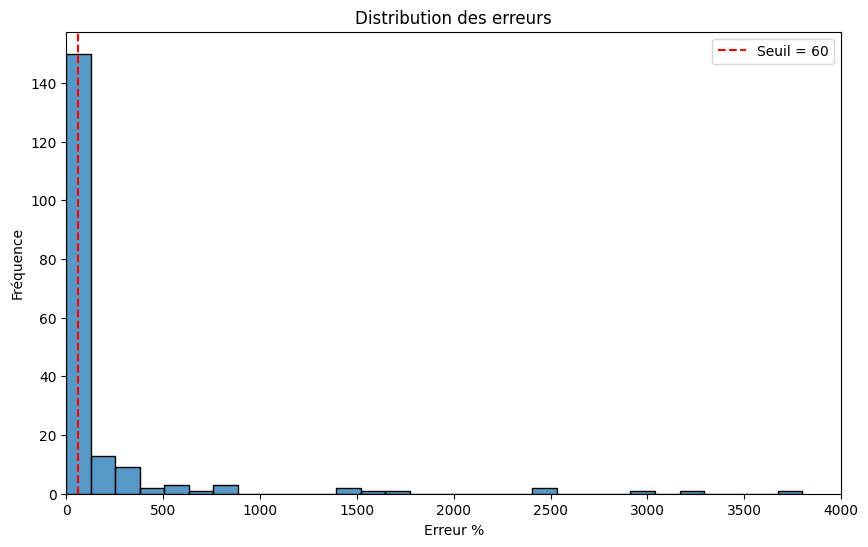

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
seuil=60
plt.figure(figsize=(10, 6))
sns.histplot(data=resultats['Erreur(%)'], bins=30)
plt.axvline(x=seuil, color='r', linestyle='--', label=f'Seuil = {seuil}')
plt.xlim(0,4000)
plt.title('Distribution des erreurs')
plt.xlabel('Erreur %')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

# ON CONTINUE LA VERIFICATION DES HYPOTHESES DE LA REGRESSION LINEAIRE


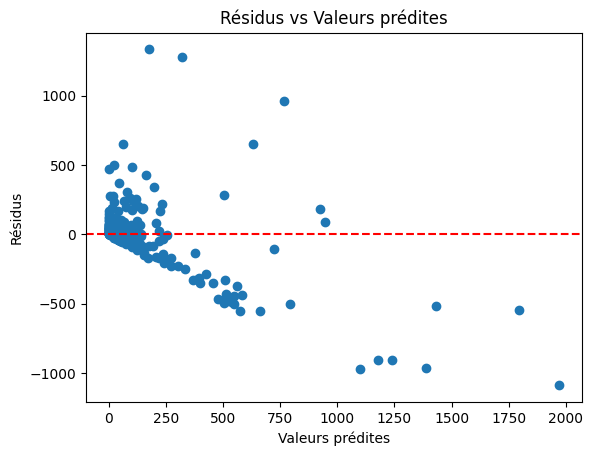

In [164]:
# Plot des résidus vs valeurs prédites
residus = y_test - y_pred_linear
plt.scatter(y_pred_linear, residus)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title('Résidus vs Valeurs prédites')
plt.show()

## 3) INDEPENDANCE DES RESIDUS (TEST DE DURBIN-WATSON)

In [165]:
from statsmodels.stats.stattools import durbin_watson
dw_test = durbin_watson(residus)
print(f"Durbin-Watson test: {dw_test}")
# Proche de 2 = bon
# <1 ou >3 = problème

Durbin-Watson test: 2.007929276172071


## 4) HOMOSCEDASTICITE (Variance constante des erreurs) (Test de Breusch-Pagan)

In [166]:
from statsmodels.stats.diagnostic import het_breuschpagan


# Ajouter une constante à X
X_avec_constante = sm.add_constant(X_test)

# Calculer les résidus 
residus = y_test - y_pred_linear

# Effectuer le test de Breusch-Pagan
test_stat, p_value, f_stat, fp_value = het_breuschpagan(residus, X_avec_constante)

print('Statistiques du test de Breusch-Pagan:')
print(f'p-value : {p_value:.4f}')
print(f'statistique de test : {test_stat:.4f}')

# Interprétation
if p_value < 0.05:
    print("Il y a de l'hétéroscédasticité (rejet de H0)")
else:
    print("Pas d'évidence d'hétéroscédasticité (non rejet de H0)")

Statistiques du test de Breusch-Pagan:
p-value : 0.0000
statistique de test : 117.2537
Il y a de l'hétéroscédasticité (rejet de H0)


## 5) NORMALITE DES RESIDUS ( QQ PLOT )

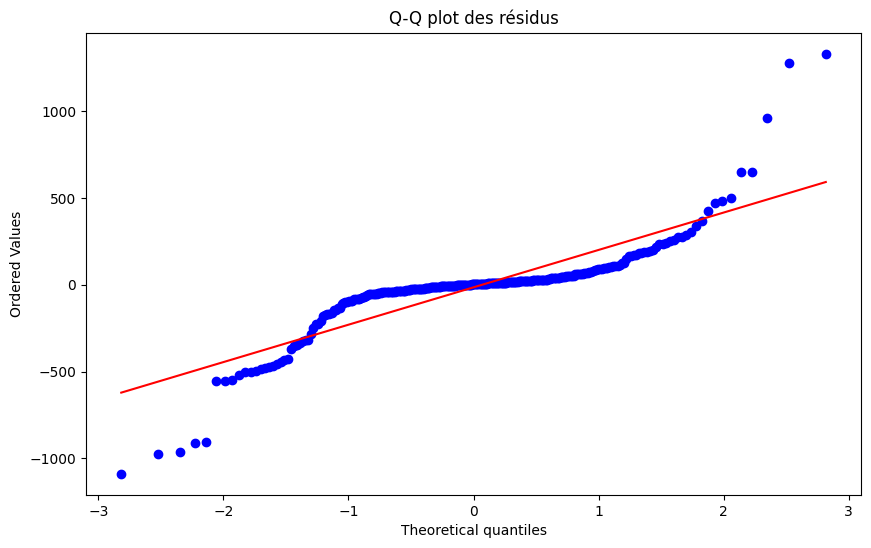

p-value du test Shapiro-Wilk : 3.74057167364453e-20


In [167]:
# QQ-plot
import scipy.stats as stats

plt.figure(figsize=(10,6))
stats.probplot(residus, dist="norm", plot=plt)
plt.title("Q-Q plot des résidus")
plt.show()

# Test de Shapiro-Wilk
_, p_value = stats.shapiro(residus)
print(f"p-value du test Shapiro-Wilk : {p_value}")
# Si p-value < 0.05 : résidus non normaux

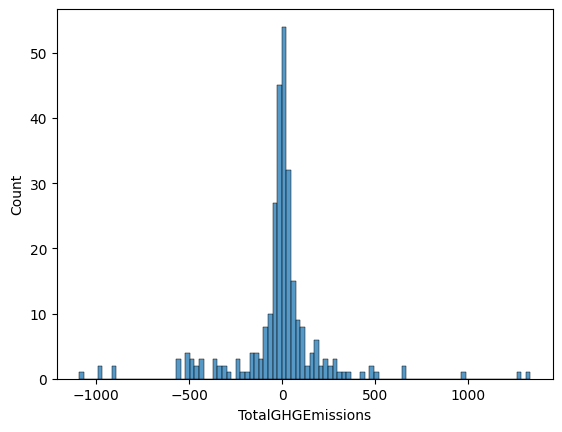

In [168]:
sns.histplot(data=residus)
plt.show()

## 6) ETUDE DES VALEURS ABERRANTES (Distance de COok)

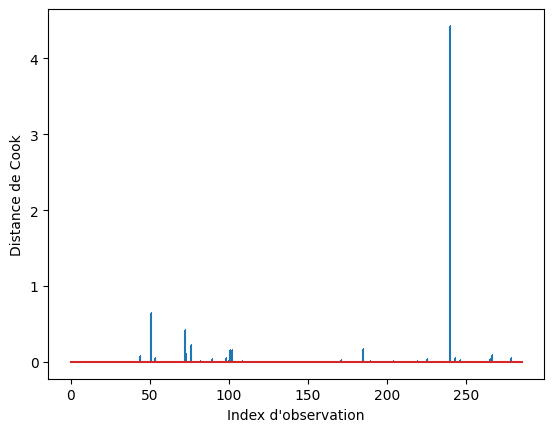

In [169]:
from statsmodels.stats.outliers_influence import OLSInfluence


# Ajuster le modèle avec statsmodels
X_sm = sm.add_constant(X_test)
model_sm = sm.OLS(y_test, X_sm).fit()

# Calculer les distances de Cook
influence = model_sm.get_influence()
cook_distance = influence.cooks_distance[0]

# Plot
plt.stem(range(len(cook_distance)), cook_distance, markerfmt=',')
plt.xlabel("Index d'observation")
plt.ylabel("Distance de Cook")
plt.show()